# Проведение AB-теста

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


## Загрузка данных

In [1]:
### импортирую необходимые библиотеки

import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [57]:
### подключаюсь к БД

connection = {
                'host': 'https://clickhouse.lab.karpov.courses',
                'password': 'dpo_python_2020',
                'user': 'student',
                'database': 'simulator_20230120'
              }


### вывожу нужный датафрейм по датам и группам

query = '''
            SELECT exp_group, 
                user_id,
                sum(action = 'like') as likes,
                sum(action = 'view') as views,
                likes/views as ctr
            FROM {db}.feed_actions 
            WHERE toDate(time) between '2023-01-01' and '2023-01-07'
                and exp_group in (1,2)
            GROUP BY exp_group, user_id
        '''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


## 1. t-тест

* H0 - средние значения CTR в контрольной и экспериментальной группaх равны.
* H1 - средние значения CTR в тестовой группе выше, чем в контрольной. 

In [43]:
stats.ttest_ind(df[df.exp_group == 2].ctr, 
                df[df.exp_group == 1].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

t-тест проведен и он показывает, что отличия незначительны, т.к. p-value > 0,05. Значит мы не можем отвергнуть Н0 о том, что средние значения CTR в тестовой группе не отличается от контрольной.

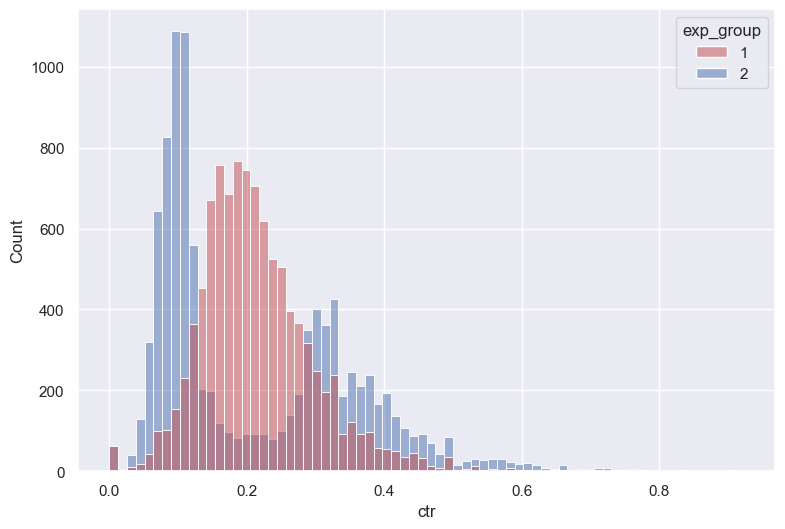

In [44]:
### делаю визуальную проверку через гистограмму

groups = sns.histplot(data = df, 
                      x='ctr', 
                      hue='exp_group', 
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

### делаю гистограмму побольше

sns.set(rc={'figure.figsize':(9, 6)})

На гистограмме видно, что есть отличия, однако, у группы 2 бимодальное распределение. Значит, t-тест не дает нам достоверную информацию. 

## 2. Тест Манна-Уитни

In [45]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни показывает мне обратную информацию, здесь видно, что p-value <<< 0,05. Данный тест позволяет отвергунть Н0. Так как два теста дали два разных результата, перехожу к повышению чувствительности метрики. Для этого воспользуюсь следующим тестом. 

## 3. Делаю тест на сглаживание CTR

In [46]:
### формирую функцию для теста

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [59]:
### добавляю столбец smothed_ctr 

df.loc[df['exp_group'] == 1, 'smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)
df.loc[df['exp_group'] == 2, 'smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

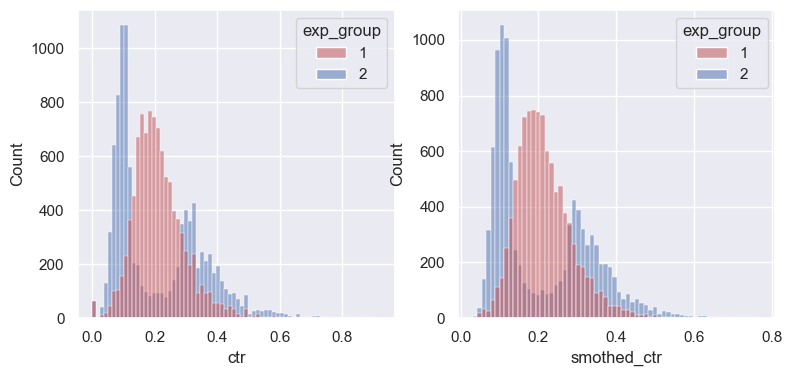

In [72]:
### сравниваю сглаженные значения CTR

f, axs = plt.subplots(1,2, figsize=(9, 4))
sns.histplot(df, x='ctr', hue='exp_group', palette=['r','b'], ax=axs[0])
sns.histplot(df, x='smothed_ctr', hue='exp_group', palette=['r','b'], ax=axs[1])

In [73]:
### делаю t-тест со обычным и сглаженным ctr

print(stats.ttest_ind(df[df.exp_group == 2].smothed_ctr, 
                    df[df.exp_group == 1].smothed_ctr,
                    equal_var=False), 'со сглаженным ctr')

print(stats.ttest_ind(df[df.exp_group == 2].ctr, 
                    df[df.exp_group == 1].ctr,
                    equal_var=False), 'с обычным ctr')

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.022376981555855876) со сглаженным ctr
Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935) с обычным ctr


In [74]:
### делаю Манна-Уитни со сглаженным ctr

print(stats.mannwhitneyu(df[df.exp_group == 2].smothed_ctr, 
                        df[df.exp_group == 1].smothed_ctr,
                        alternative = 'two-sided'), 'со сглаженным ctr')

print(stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                        df[df.exp_group == 1].ctr,
                        alternative = 'two-sided'), 'с обычным ctr')

MannwhitneyuResult(statistic=43381083.0, pvalue=1.6163964114270227e-61) со сглаженным ctr
MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56) с обычным ctr


С помощью сглаживания ctr результат по t-тест стал более правдоподобным, т.к. p-value < 0,05. Тест Манна-Уитни также показывает  p-value <<< 0,05. Для чистоты эксперемента проведу еще несколько тестов. Данный метод позволяет нам отвергнуть Н0.

## 4. Пуассоновский бутстреп для подсчета разницы в CTR

Пуассоновский бутстреп - все лайки делить на все показы в группе, т.е. выдает общегрупповой ctr. Бутстреп сравнивает общий ctr двух групп. Другими словами, мы генерируем из общей выборки псевдовыборки с возвращением. И эти псевдовыборки сравнивем между собой как ГС.

In [75]:
### формирую функцию для бутстрепа

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    ### 2000 раз генерирую веса из распределения Пуассона
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)  
    ### расчитываю ctr
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [76]:
### достаю лайки и просмотры для контрольной и эксперементальной группы

likes1 = df_g1.likes.to_numpy()
views1 = df_g1.views.to_numpy()
likes2 = df_g2.likes.to_numpy()
views2 = df_g2.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

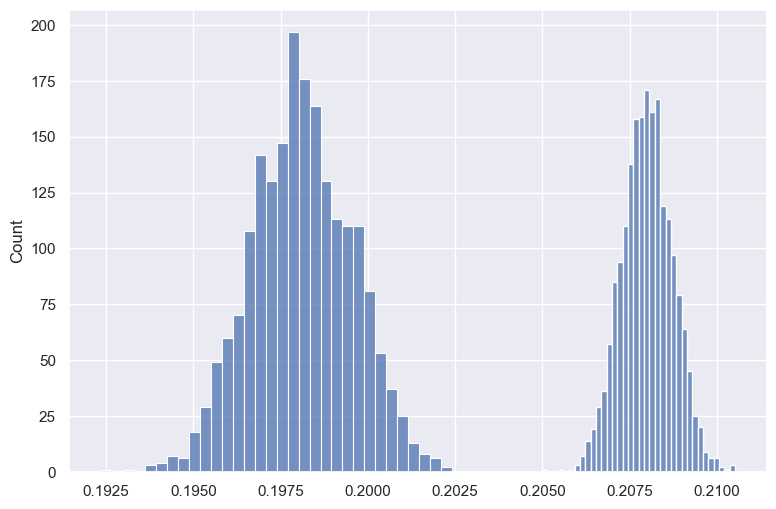

In [77]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Видно, что два распределение даже не пересекаются на гистограмме, а значит, p-value стремится к 0. Поэтому можно утверждать, что в одной из групп глобальный ctr больше, чем в другой. 

<AxesSubplot:ylabel='Count'>

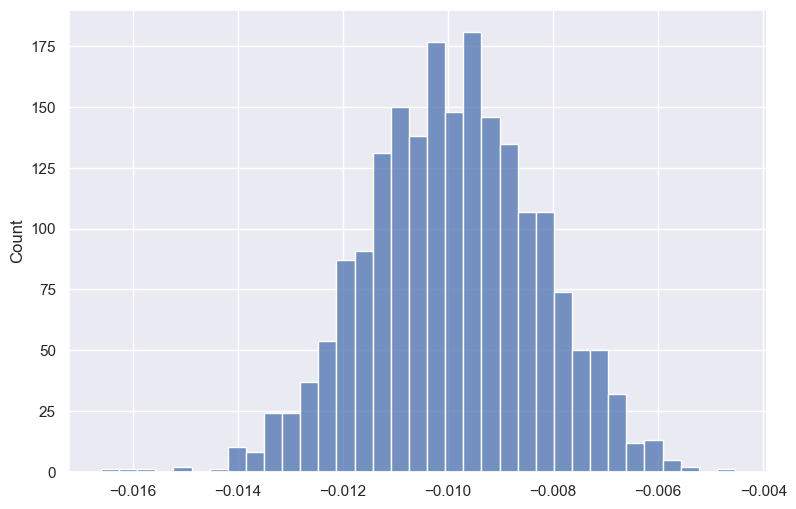

In [78]:
### разница между глобальными CTR в Пуассоновском бутстрепе

sns.histplot(ctr2 - ctr1)

Гистограмма разности не пересекает 0, а значит, одна группа по ctr строго больше другой. ctr2 - это эксперементальная группа, ctr1 - контрольная. Получается, что распределение не пересекает 0 и находится левее от него, а значит, глобальный ctr в контрольной группе выше, чем в эксперементальной. Значит мы не можем отвергать Н0.

## 5. Бакетное преобразование

Мы берем наших пользователей и случайным образом делим их на n ведерок(bucket). Нужно гарантировать, что каждый пользователь, в каждой группе попадет ровно в один бакет. Пользователи по бакетам должны быть распределены равномерно. Каждый бакет мы рассматривает как метапользователя и внутри этого метапользователя нам нужно сагригировать показатели для сравнения. 

In [79]:
### делаю разбивку прямо в кликхаусе

query = '''
            SELECT exp_group, bucket,
                sum(likes)/sum(views) as bucket_ctr,
                quantileExact(0.9)(ctr) as ctr9
            FROM (SELECT exp_group, 
                    xxHash64(user_id)%50 as bucket,
                    user_id,
                    sum(action = 'like') as likes,
                    sum(action = 'view') as views,
                    likes/views as ctr
                FROM {db}.feed_actions 
                WHERE toDate(time) between '2023-01-01' and '2023-01-07'
                        and exp_group in (1,2)
                GROUP BY exp_group, bucket, user_id)
            GROUP BY exp_group, bucket
        '''

df_bucket = ph.read_clickhouse(query, connection=connection)


In [87]:
df_bucket

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314
...,...,...,...,...
95,2,47,0.195880,0.426230
96,1,48,0.212787,0.318182
97,2,48,0.194502,0.409091
98,1,49,0.203169,0.325581


In [80]:
### создаю отдельный дф для каждой группы

df_bucket_g1 = df_bucket[df_bucket.exp_group == 1]
df_bucket_g2 = df_bucket[df_bucket.exp_group == 2]

In [81]:
### сравниваю средний побекетный ctr в тесте Манна-Уитни

stats.mannwhitneyu(df_bucket_g1.bucket_ctr, 
                   df_bucket_g2.bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

При бакетном распределении тест Манна-Уитни показывает разницу. Можно отвергнуть Н0.

In [82]:
### t-тест 

stats.ttest_ind(df_bucket_g1.bucket_ctr, 
                df_bucket_g2.bucket_ctr, 
                equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

При бакетном распределении тест t-тесте также видит разницу. Можно отвергнуть Н0.

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

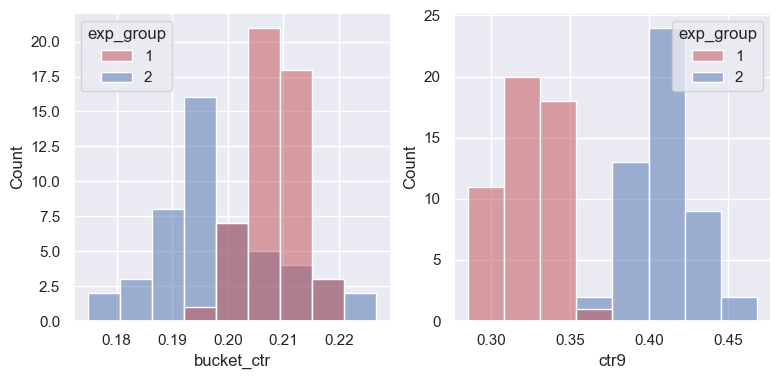

In [90]:
f, axs = plt.subplots(1,2, figsize=(9, 4))
### строю гистограмму для 1 и 2 группы 
sns.histplot(df_bucket, x='bucket_ctr', hue='exp_group', palette=['r','b'], ax=axs[0])
### строю гистограмму для 1 и 2 группы с 90% квантилем
sns.histplot(df_bucket, x='ctr9', hue='exp_group', palette=['r','b'], ax=axs[1])

In [86]:
### делаю сравнение по 90% квантилям

stats.mannwhitneyu(df_bucket_g1.ctr9, 
                   df_bucket_g2.ctr9, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

Визуально сравнивая гистограммы видно, что в распределении по 2 группе мода находится левее моды из группы 1, а значит, можно сделать вывод, что побакетный ctr в 1 контрольной группе выше. При тестировании ctr по 90% квантилям видно, что вторая группа показыает более высокий ctr. Данные не однозначны. 

## Вывод

При проведении 5 различных тестов выборки по 1 и 2 группе различаются. Показатели говорят, что ctr во 2 эксперементальной группе маньше, чем в 1 контрольной. Результаты A/B теста подтверждают, что в большинстве случаев контрольная группа показала выше показатели ctr, а значит **Н1 отвергаем** и раскатывать новый алгоритм на всех новых пользователях не стоит.